In [1]:
#Loads some parameters
import CloudDataset128c
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 7

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([7, 12, 128, 128])
torch.Size([7, 6, 128, 128])


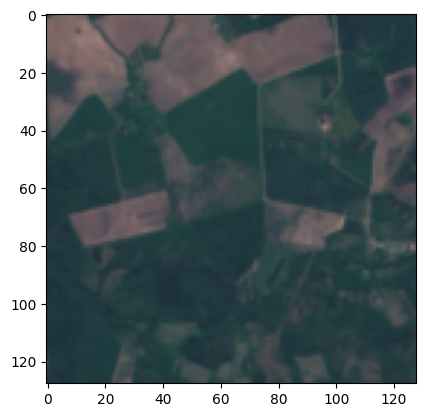

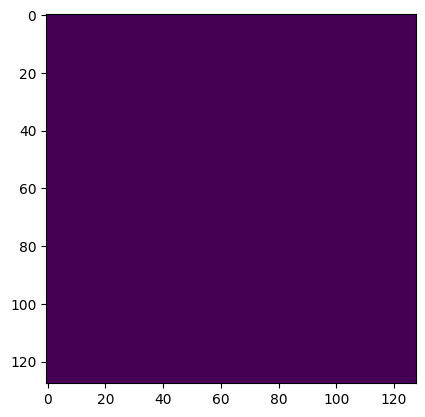

In [2]:
transform = {
    "image": v2.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": v2.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128c.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

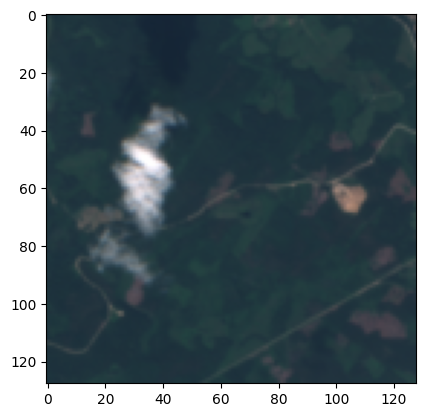

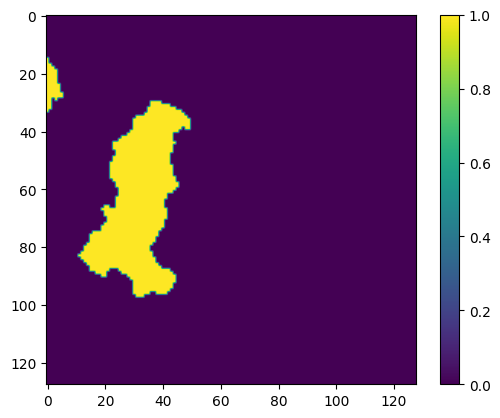

In [3]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels = next(it)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x12
        self.e11 = nn.Conv2d(12, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class

        #Dropout
        self.dropout = nn.Dropout(0.85)
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        xed11 = self.dropout(xe11)
        #print(xe11.shape)
        xe12 = relu(self.e12(xed11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        xed21 = self.dropout(xe21)
        #print(xe21.shape)
        xe22 = relu(self.e22(xed21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        xed31 = self.dropout(xe31)
        #print(xe31.shape)
        xe32 = relu(self.e32(xed31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        xed41 = self.dropout(xe41)
        #print(xe41.shape)
        xe42 = relu(self.e42(xed41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        xed51 = self.dropout(xe51)
        #print(xe51.shape)
        xe52 = relu(self.e52(xed51))
        #print(xe52.shape)
        xp5 = self.pool5(xe52)
        #print(xp5.shape)

        xe61 = relu(self.e61(xp5))
        xed61 = self.dropout(xe61)
        #print(xe51.shape)
        xe62 = relu(self.e62(xed61))
        #print(xe52.shape)
        
        # Decoder
        xu0 = self.upconv0(xe62)
        xu01 = torch.cat([xu0, xe52], dim=1)
        xd01 = relu(self.d01(xu01))
        xdd01 = self.dropout(xd01)
        xd02 = relu(self.d02(xdd01))

        xu1 = self.upconv1(xd02)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xdd11 = self.dropout(xd11)
        xd12 = relu(self.d12(xdd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xdd21 = self.dropout(xd21)
        xd22 = relu(self.d22(xdd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xdd31 = self.dropout(xd31)
        xd32 = relu(self.d32(xdd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xdd41 = self.dropout(xd41)
        xd42 = relu(self.d42(xdd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 2.9075737000093795 Time_diff: 2.9075746000016807 loss: 2.0504186153411865
Epoch: 0 batch_nr: 8 Time: 64.69625070001348 Time_diff: 7.683109500008868 loss: 2.425570766131083
new val loss: 2.005695104598999
Epoch: 1 batch_nr: 7 Time: 141.39918010000838 Time_diff: 8.17669079999905 loss: 2.137931138277054
new val loss: 20.878271102905273
Epoch: 2 batch_nr: 6 Time: 217.70520390001184 Time_diff: 7.732076999993296 loss: 2.2193606240408763
new val loss: 5.364210605621338
Epoch: 3 batch_nr: 5 Time: 294.95626090001315 Time_diff: 7.571238700009417 loss: 2.2416588068008423
new val loss: 7.371090412139893
Epoch: 4 batch_nr: 4 Time: 372.2798104000103 Time_diff: 7.697181700001238 loss: 2.210462951660156
new val loss: 1.8172577619552612
Epoch: 5 batch_nr: 3 Time: 448.8332480000099 Time_diff: 7.586770800000522 loss: 1.903184711933136
new val loss: 2.0745134353637695
Epoch: 6 batch_nr: 2 Time: 523.8740279000049 Time_diff: 7.592250000001513 loss: 2.0059163570404053
Epoch: 6 batc

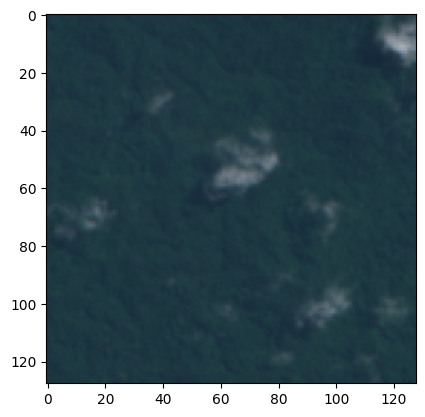

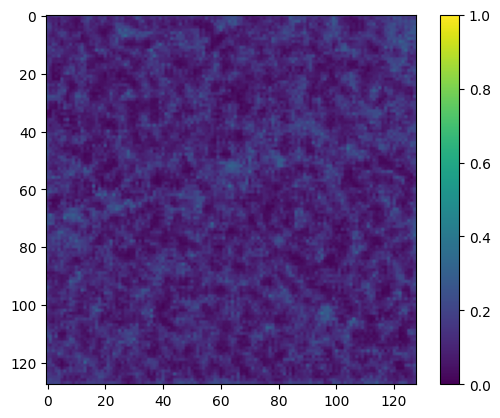

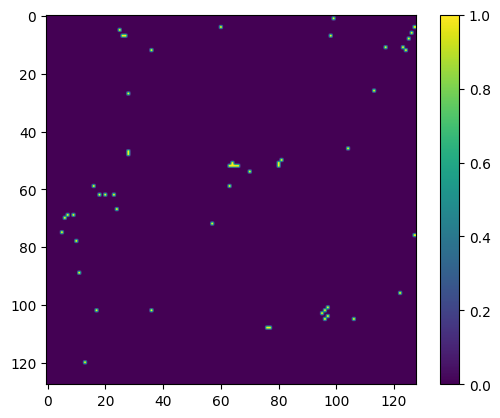

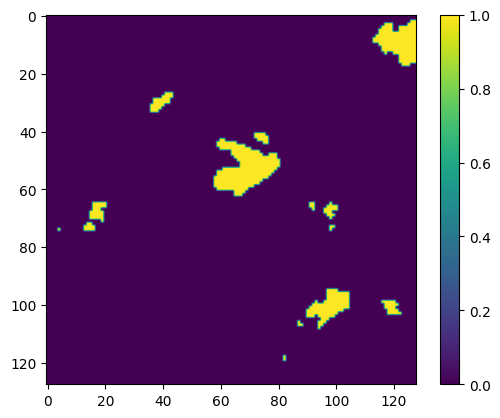

Epoch: 18 batch_nr: 6 Time: 1568.992726700002 Time_diff: 7.876648100005696 loss: 1.8907924209322249
new val loss: 4.29837703704834
Epoch: 19 batch_nr: 5 Time: 1645.9194378000102 Time_diff: 7.67555889999494 loss: 1.9403443336486816
new val loss: 25.963836669921875
Epoch: 20 batch_nr: 4 Time: 1722.7807616000064 Time_diff: 7.718564499999047 loss: 1.8287404775619507
new val loss: 1.6504287719726562
Epoch: 21 batch_nr: 3 Time: 1799.2757476000115 Time_diff: 7.816276899990044 loss: 1.9686985611915588
new val loss: 1.5763355493545532
Epoch: 22 batch_nr: 2 Time: 1875.5152382000088 Time_diff: 7.810379100003047 loss: 1.9722696940104167
Epoch: 22 batch_nr: 10 Time: 1935.7058312000008 Time_diff: 5.086106000002474 loss: 1.8566185344349255
new val loss: 43.3078727722168
Epoch: 23 batch_nr: 1 Time: 1952.8622350000078 Time_diff: 7.697317600002862 loss: 1.9375043511390686
Epoch: 23 batch_nr: 9 Time: 2023.1803870000003 Time_diff: 9.380982700007735 loss: 1.859765636920929
new val loss: 1.784285306930542
E

KeyboardInterrupt: 

In [6]:
import copy
from time import perf_counter
import random

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0


    best_loss = 1.5 #float('inf')

    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        
        #Grabs next iterator batch, restarts if at end of iterator
        try:
            images_valid, labels_valid = next(iterator)
        except:
            iterator = iter(val_loader)
            images_valid, labels_valid = next(iterator)


        #Forward - Validation
        predictions = model(images_valid)
        v_loss = criterion(predictions,labels_valid.float())
        
        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append(v_loss.item())

        #Finds best model
        if (v_loss<best_loss):
            best_loss=v_loss.item()
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128d_model.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            i=4

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
        else:
            print("new val loss:",v_loss.item())
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = torch.load("best_UNET128d_model.pt")
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [7]:
test_dataset = CloudDataset128c.CloudDataset("data\\train",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128d_model.pt").eval()
criterion = nn.CrossEntropyLoss()
predictions = best_model(images)

In [9]:
images,labels = next(test_it)
predictions = best_model(images)

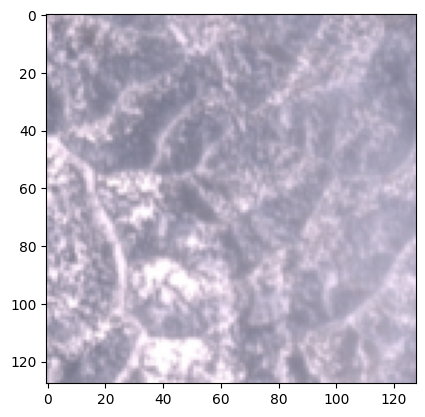

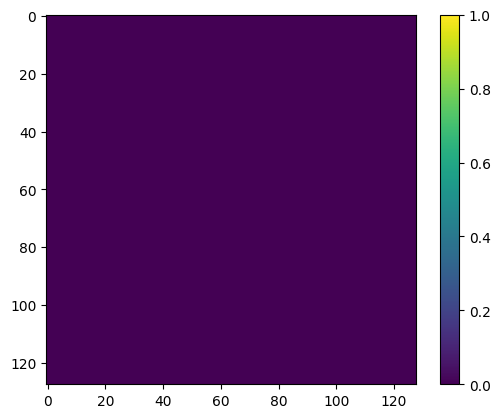

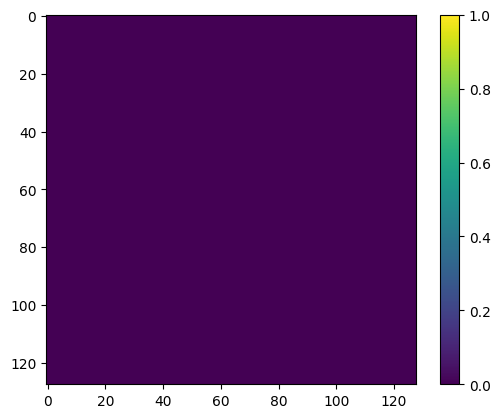

loss: tensor(1.4489, grad_fn=<DivBackward1>)


In [10]:

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

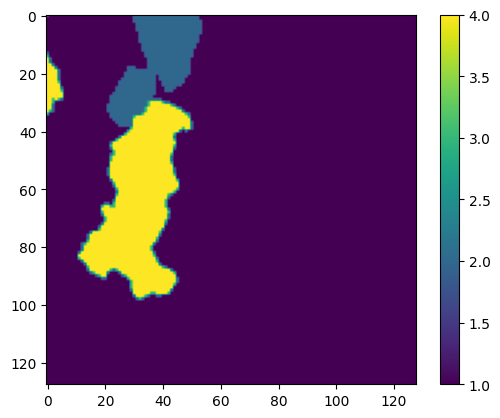

In [8]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [35]:
images,labels = next(test_it)
predictions = best_model(images)

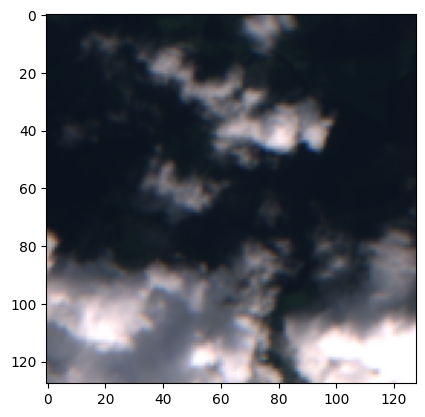

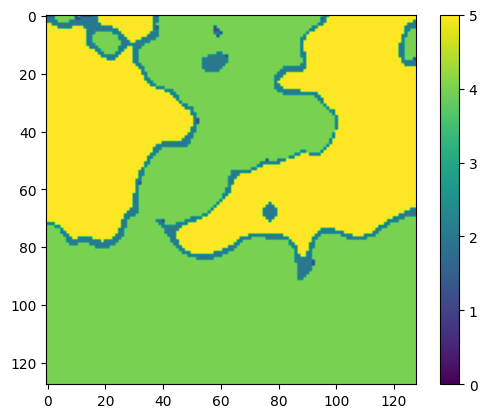

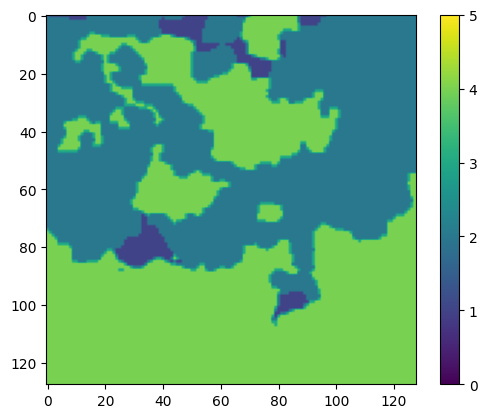

loss: tensor(1.0873, grad_fn=<DivBackward1>)


In [12]:
images,labels = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

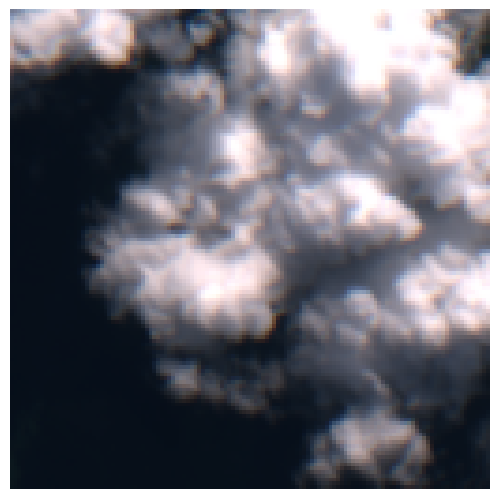

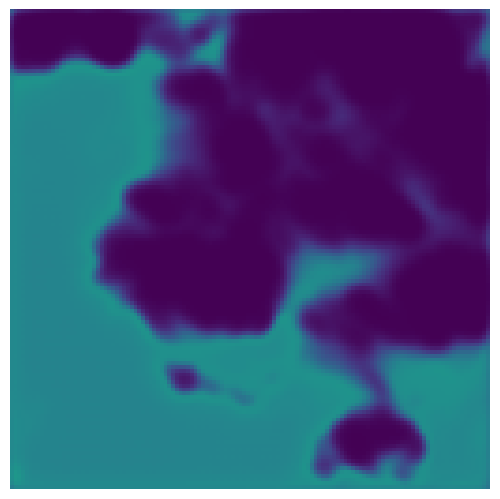

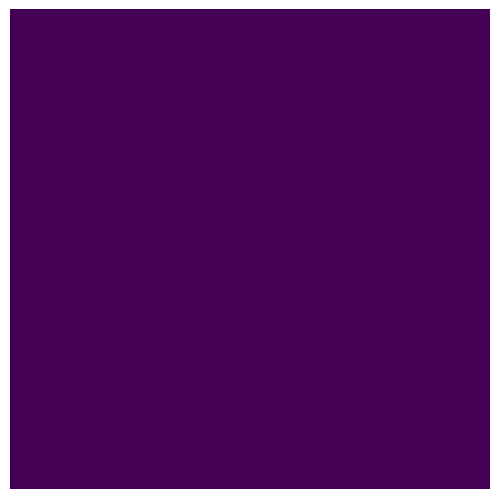

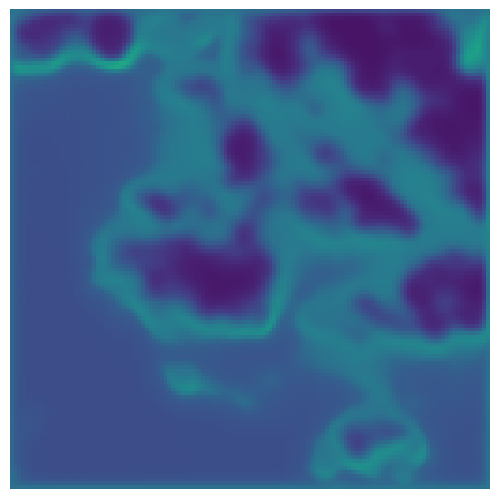

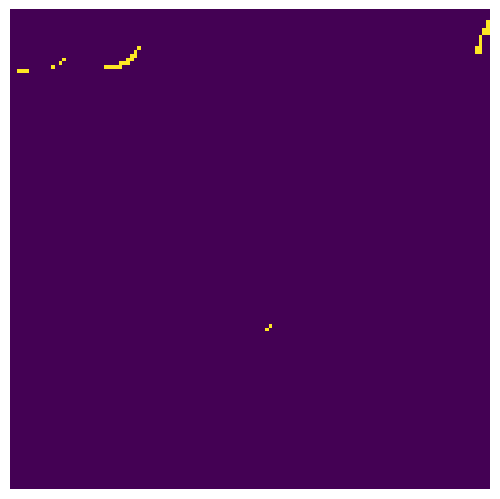

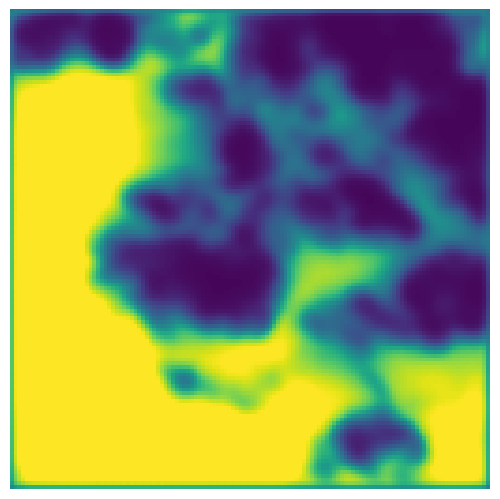

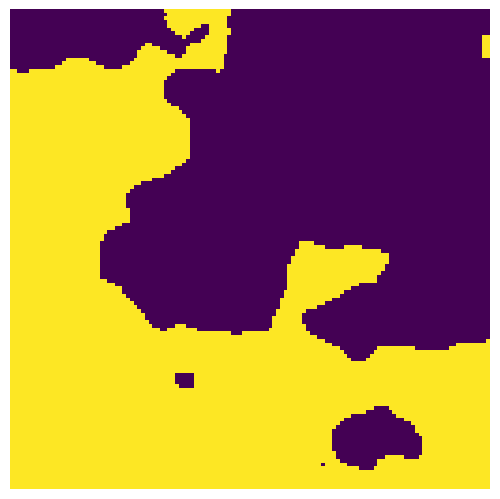

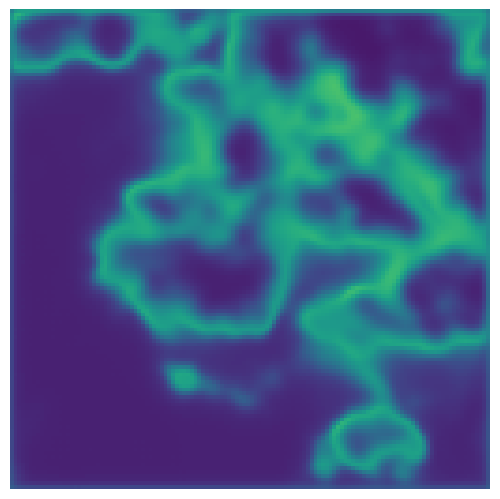

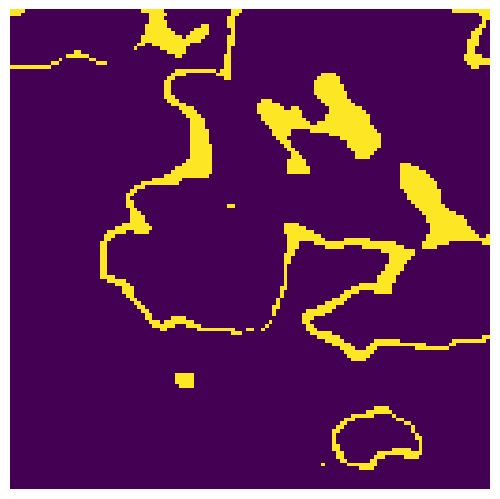

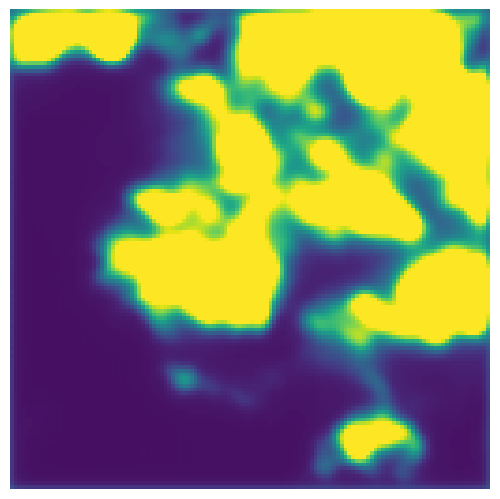

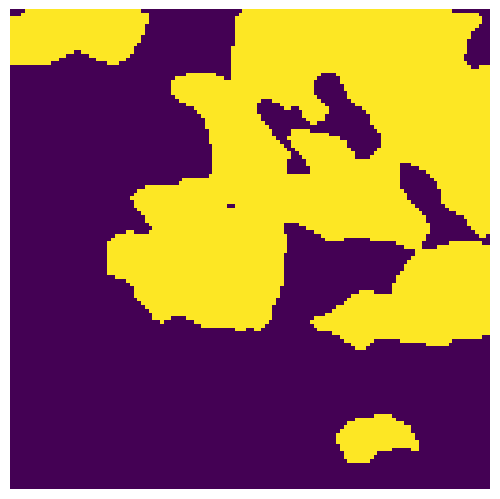

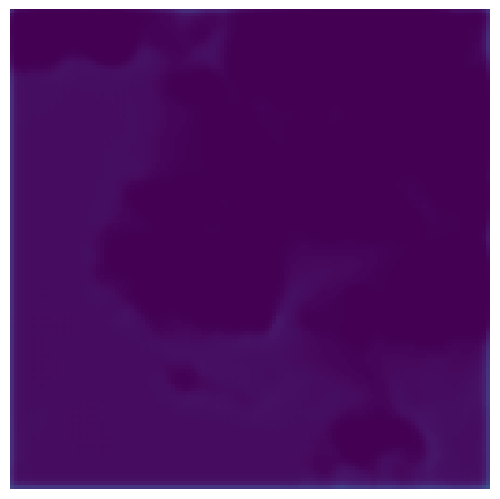

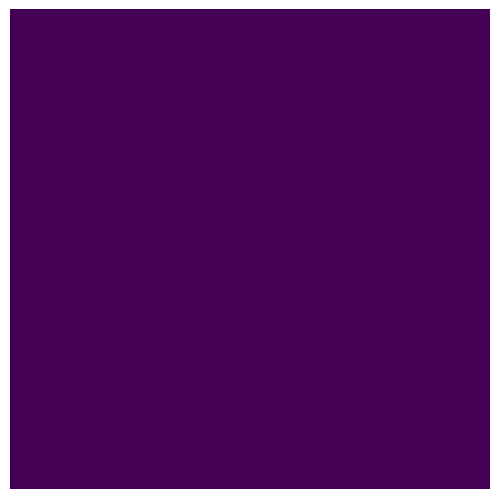

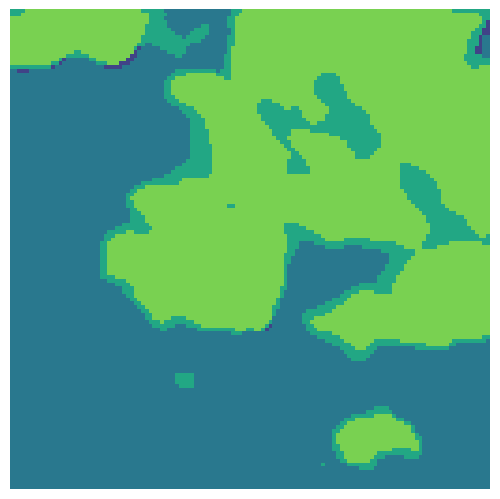

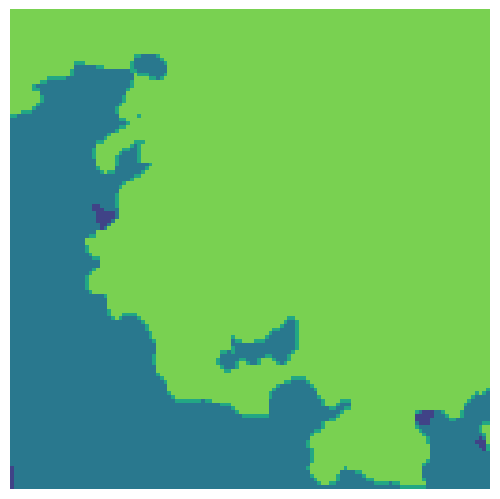

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [50]:
#For creating images

predictions = best_model(images)

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

for i in range(6):

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_softmax[0][i:i+1].permute(1,2,0),vmin=0, vmax=0.5)
    plt.savefig('softmax'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
    plt.savefig('binary'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()



fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('predictions.jpg', bbox_inches='tight',pad_inches=0)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('label.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))


In [63]:
_,labels = next(iter(training_loader))

In [81]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    vs[i]=m/e
print(vs)

[830, 521225, 199987, 339080, 326761, 70293]
[627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]


In [9]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels) in enumerate(training_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.4789)
